<a href="https://colab.research.google.com/github/petegordon/AlpacaAPI/blob/main/LSTM_SPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup (Google Drive, Imports, Read CSV)

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install tensorflow

# 1. First, make sure your imports are correct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler



In [3]:
#Load MyDrive/PersonalData/spy_bars.csv into DataFrame

# Step: Load the CSV into a DataFrame
file_path = './spy_bars.csv'
df = pd.read_csv(file_path)

# Step: Display the first few rows
df.head()


,id,open,high,low,close,volume,number_of_trades,bar_ts,trade_date,trade_time,...,momentum_10,stddev_10,relative_volume_30,minutes_since_open,bar_num,high_since_open,low_since_open,cumulative_volume,open_at_930am,close_at_4pm
0,4bbe824c-254d-4fec-89ab-e4671d83dcc3,384.00,386.54,384.00,386.51,26198,289,2023-01-03 09:00:00+00:00,2023-01-03,09:00:00,...,0.0,0.388909,1.000000,-1.0,1,386.54,384.0,26198.0,386.68,382.04
1,4bbe824c-254d-4fec-89ab-e4671d83dcc3,386.50,386.53,385.91,385.96,50073,182,2023-01-03 09:05:00+00:00,2023-01-03,09:05:00,...,0.0,0.388909,1.313029,-1.0,2,386.54,384.0,76271.0,386.68,382.04
2,4bbe824c-254d-4fec-89ab-e4671d83dcc3,386.18,386.51,386.13,386.51,7497,70,2023-01-03 09:10:00+00:00,2023-01-03,09:10:00,...,0.0,0.317543,0.268492,-1.0,3,386.54,384.0,83768.0,386.68,382.04
3,4bbe824c-254d-4fec-89ab-e4671d83dcc3,386.54,386.79,386.28,386.28,8990,106,2023-01-03 09:15:00+00:00,2023-01-03,09:15:00,...,0.0,0.260320,0.387675,-1.0,4,386.79,384.0,92758.0,386.68,382.04
4,4bbe824c-254d-4fec-89ab-e4671d83dcc3,386.48,386.70,386.48,386.70,3736,40,2023-01-03 09:20:00+00:00,2023-01-03,09:20:00,...,0.0,0.283672,0.193587,-1.0,5,386.79,384.0,96494.0,386.68,382.04


# Lastest and Greatest Functions

In [4]:
def load_and_preprocess_data(csv_path):
    """Load and preprocess the SPY bar data"""
    print("Loading and preprocessing data...")

    # Load the CSV data directly
    df = pd.read_csv(csv_path)

    # Convert trade_date to datetime
    df["trade_date"] = pd.to_datetime(df["trade_date"])

    # Convert trade_time to datetime.time objects consistently
    if "trade_time" in df.columns:
        if isinstance(df["trade_time"].iloc[0], str):
            # Convert string time to datetime.time objects
            df["trade_time"] = pd.to_datetime(df["trade_time"], errors='coerce').dt.time

    # Filter incomplete rows
    df = df[df["close"].notnull()].copy()

    # Sort by timestamp
    df = df.sort_values("bar_ts")

    # Drop forward-looking features
    df = df.drop(columns=["next_close", "next_bar_return"], errors='ignore')

    # Fill or drop missing values
    df["momentum_5"] = df["momentum_5"].fillna(0)
    df["momentum_10"] = df["momentum_10"].fillna(0)
    df["stddev_10"] = df["stddev_10"].bfill().fillna(0)

    # Forward fill open_at_930am per day
    df["open_at_930am"] = df.groupby("trade_date")["open_at_930am"].transform(lambda x: x.ffill().bfill())

    # Fill minutes_since_open with -1 to indicate non-market hours
    df["minutes_since_open"] = df["minutes_since_open"].fillna(-1)

    print(f"Preprocessed data shape: {df.shape}")
    print(f"Date range: {df['trade_date'].min()} to {df['trade_date'].max()}")

    return df



In [5]:
def calculate_reference_prices(df, reference_hour=11, reference_minute=0):
    """Calculate reference price at the specified time for each trading day"""
    print(f"Calculating reference prices at {reference_hour}:{reference_minute}...")

    # Make a copy to avoid SettingWithCopyWarning
    df = df.copy()

    # Ensure trade_time is properly formatted
    if "trade_time" in df.columns and len(df) > 0:
        if isinstance(df["trade_time"].iloc[0], str):
            try:
                df["trade_time"] = pd.to_datetime(df["trade_time"], errors='coerce').dt.time
            except Exception as e:
                print(f"Warning: Could not convert trade_time to datetime: {e}")
                # Create a fallback time column for comparison
                df["time_for_comparison"] = df["trade_time"]

    unique_dates = df['trade_date'].unique()
    print(f"Found {len(unique_dates)} unique trading days")

    # Create a reference time object for comparison
    from datetime import time
    reference_time = time(reference_hour, reference_minute)

    # Prepare a list to hold results
    reference_price_data = []

    # For each trading day, find the price at the reference time
    for date in unique_dates:
        day_data = df[df['trade_date'] == date].copy()

        if len(day_data) == 0:
            print(f"No data for date {date}")
            continue

        try:
            # Determine which column to use for time comparison
            time_column = "trade_time"
            if "time_for_comparison" in day_data.columns:
                time_column = "time_for_comparison"

            # Debug output
            #print(f"Processing date {date}, time column: {time_column}, data shape: {day_data.shape}")

            # Try to find bars before or at reference time
            # Handle different time formats
            if isinstance(day_data[time_column].iloc[0], time):
                # It's already a time object
                bars_before_reference = day_data[day_data[time_column] <= reference_time]
            elif isinstance(day_data[time_column].iloc[0], str):
                # It's a string, try string comparison
                reference_str = f"{reference_hour:02d}:{reference_minute:02d}:00"
                bars_before_reference = day_data[day_data[time_column] <= reference_str]
            else:
                # Use all data as fallback
                print(f"Warning: Unrecognized time format for {date}, using all data")
                bars_before_reference = day_data

            if len(bars_before_reference) > 0:
                # Get the bar closest to reference time (the last one before reference time)
                # Sort by timestamp if available
                if "bar_ts" in bars_before_reference.columns:
                    last_bar = bars_before_reference.sort_values('bar_ts', ascending=False).iloc[0]
                else:
                    last_bar = bars_before_reference.sort_values(time_column, ascending=False).iloc[0]

                reference_price = last_bar['close']

                # Add to results
                reference_price_data.append({
                    'trade_date': date,
                    'reference_price': reference_price
                })
                #print(f"Found reference price for {date}: {reference_price}")
            else:
                # If no bars before reference time, use first bar of the day
                if "bar_ts" in day_data.columns:
                    first_bar = day_data.sort_values('bar_ts').iloc[0]
                else:
                    first_bar = day_data.sort_values(time_column).iloc[0]

                reference_price_data.append({
                    'trade_date': date,
                    'reference_price': first_bar['close']
                })
                print(f"No bars before reference time for {date}, using first bar price: {first_bar['close']}")

        except Exception as e:
            print(f"Error processing date {date}: {e}")
            # Try to get any price for this day as fallback
            try:
                reference_price_data.append({
                    'trade_date': date,
                    'reference_price': day_data.iloc[0]['close']
                })
                print(f"Using fallback price for {date}: {day_data.iloc[0]['close']}")
            except:
                print(f"Could not get any price for {date}")

    # Create a DataFrame from the results
    reference_price_df = pd.DataFrame(reference_price_data)
    print(f"Generated reference prices for {len(reference_price_df)} trading days")

    # Debug: Print the reference price dataframe
    print("\nSample of reference prices dataframe:")
    print(reference_price_df.head())

    # Merge back with original DataFrame
    df_with_reference = pd.merge(df, reference_price_df, on='trade_date', how='left')

    # Calculate price change from reference time to close
    if 'close_at_4pm' in df_with_reference.columns:
        df_with_reference['price_change_reference_to_close'] = df_with_reference['close_at_4pm'] - df_with_reference['reference_price']

        print(f"Null reference prices: {df_with_reference['reference_price'].isna().sum()} out of {len(df_with_reference)}")
        print(f"Null close_at_4pm: {df_with_reference['close_at_4pm'].isna().sum()} out of {len(df_with_reference)}")
        print(f"Null price_change: {df_with_reference['price_change_reference_to_close'].isna().sum()} out of {len(df_with_reference)}")
    else:
        print("WARNING: 'close_at_4pm' column not found! Cannot calculate price change.")

    # Create a sample to verify data
    if 'close_at_4pm' in df_with_reference.columns:
        sample = df_with_reference[['trade_date', 'reference_price', 'close_at_4pm', 'price_change_reference_to_close']
                             ].drop_duplicates('trade_date').head(5)
        print("\nSample reference and close prices:")
        print(sample)
    else:
        sample = df_with_reference[['trade_date', 'reference_price']].drop_duplicates('trade_date').head(5)
        print("\nSample reference prices (close_at_4pm not available):")
        print(sample)

    # Debug info about columns
    print("\nColumns in result dataframe:")
    print(df_with_reference.columns.tolist())

    return df_with_reference



In [6]:
def build_lstm_sequences(df, features, lookback_days=7, cutoff_time=time(12, 0)):
    """Build input sequences for the LSTM model"""
    print(f"\nBuilding LSTM sequences with {lookback_days} days lookback...")

    # Ensure trade_date is in datetime format
    df = df.copy()
    df["trade_date"] = pd.to_datetime(df["trade_date"])

    # Make sure trade_time is properly handled
    if "trade_time" in df.columns and len(df) > 0:
        if isinstance(df["trade_time"].iloc[0], str):
            try:
                df["trade_time"] = pd.to_datetime(df["trade_time"], errors='coerce').dt.time
            except Exception as e:
                print(f"Warning: Could not convert trade_time to datetime: {e}")
                # Create a fallback column
                df["time_for_comparison"] = df["trade_time"]

    # Debug output
    print("\nChecking for reference_price column in dataframe:")
    print(f"Columns available: {df.columns.tolist()}")
    if 'reference_price' in df.columns:
        print(f"Reference price column exists, sample values: {df['reference_price'].head()}")
    else:
        print("WARNING: reference_price column is MISSING!")
        return np.array([]), np.array([]), [], np.array([])

    # Print feature list with dtypes
    print("\nFeature list:")
    for feature in features:
        if feature in df.columns:
            print(f"  {feature}: {df[feature].dtype}")
        else:
            print(f"  {feature}: NOT FOUND")

    # Get unique dates sorted chronologically
    trade_dates = sorted(df["trade_date"].unique())
    print(f"Total trading days: {len(trade_dates)}")

    # Define sequence parameters
    expected_bars_per_day = 390
    current_day_bars_cutoff = 30
    sequence_length = lookback_days * expected_bars_per_day + current_day_bars_cutoff

    # Prepare containers for sequences
    X, y, date_labels, reference_prices = [], [], [], []

    # Loop through dates to build sequences
    sequences_built = 0
    sequences_skipped = 0

    for i in range(lookback_days, len(trade_dates)):
        past_dates = trade_dates[i - lookback_days:i]
        target_date = trade_dates[i]

        try:
            # Get past days' data
            past_data = df[df["trade_date"].isin(past_dates)]
            if len(past_data) == 0:
                print(f"No past data for dates {past_dates}")
                sequences_skipped += 1
                continue

            # Get current day's data up to cutoff time
            day_data = df[df["trade_date"] == target_date]

            if len(day_data) == 0:
                print(f"No data for target date {target_date}")
                sequences_skipped += 1
                continue

            # Determine which column to use for time comparison
            time_column = "trade_time"
            if "time_for_comparison" in day_data.columns:
                time_column = "time_for_comparison"

            # Get data up to cutoff time
            try:
                if isinstance(day_data[time_column].iloc[0], time):
                    # It's already a time object
                    current_data = day_data[day_data[time_column] <= cutoff_time]
                elif isinstance(day_data[time_column].iloc[0], str):
                    # It's a string, try string comparison
                    cutoff_str = f"{cutoff_time.hour:02d}:{cutoff_time.minute:02d}:00"
                    current_data = day_data[day_data[time_column] <= cutoff_str]
                else:
                    # Use first 30 minutes as fallback
                    print(f"Warning: Unrecognized time format for {target_date}, using first 30 rows")
                    current_data = day_data.head(30)
            except Exception as e:
                print(f"Error filtering by time for {target_date}: {e}")
                current_data = day_data.head(30)  # Fallback

            if len(current_data) == 0:
                print(f"No current data up to cutoff time for {target_date}")
                sequences_skipped += 1
                continue

            # Get target values for this date
            target_data = df[(df["trade_date"] == target_date) &
                            (df["reference_price"].notna())]

            if 'close_at_4pm' in df.columns:
                target_data = target_data[target_data["close_at_4pm"].notna()]

            if len(target_data) == 0:
                print(f"No target data for {target_date}")
                sequences_skipped += 1
                continue

            # Get reference price and close price for this date
            reference_price = target_data["reference_price"].iloc[0]

            # Calculate price change
            if 'close_at_4pm' in target_data.columns:
                close_price = target_data["close_at_4pm"].iloc[0]
                price_change = close_price - reference_price
            else:
                # If close_at_4pm is not available, use last available close of the day
                day_end_data = df[df["trade_date"] == target_date].sort_values("bar_ts", ascending=False)
                if len(day_end_data) > 0:
                    close_price = day_end_data.iloc[0]["close"]
                    price_change = close_price - reference_price
                else:
                    print(f"No day end data for {target_date}")
                    sequences_skipped += 1
                    continue

            # Combine past and current data
            sequence_df = pd.concat([past_data, current_data])

            # Check for missing features
            missing_features = [f for f in features if f not in sequence_df.columns]
            if missing_features:
                print(f"Missing features for date {target_date}: {missing_features}")
                sequences_skipped += 1
                continue

            # Extract feature values
            features_only = sequence_df[features].values

            # Handle sequence length (pad or truncate)
            if len(features_only) < sequence_length:
                pad_len = sequence_length - len(features_only)
                padded = np.pad(features_only, ((pad_len, 0), (0, 0)), mode="constant", constant_values=0)
            elif len(features_only) > sequence_length:
                padded = features_only[-sequence_length:]
            else:
                padded = features_only

            # Store the sequence
            X.append(padded)
            y.append(price_change)
            date_labels.append(target_date)
            reference_prices.append(reference_price)

            sequences_built += 1
            if sequences_built % 50 == 0:
                print(f"Built {sequences_built} sequences so far...")

        except Exception as e:
            print(f"Error building sequence for date {target_date}: {e}")
            import traceback
            traceback.print_exc()
            sequences_skipped += 1

    print(f"Sequences built: {sequences_built}, Sequences skipped: {sequences_skipped}")

    if sequences_built == 0:
        print("WARNING: No valid sequences could be built!")
        return np.array([]), np.array([]), [], np.array([])

    return np.array(X), np.array(y), date_labels, np.array(reference_prices)


In [7]:

# The following functions remain unchanged from your original code
def split_dataset(X, y, dates, noon_prices, train_ratio=0.7, val_ratio=0.15):
    """Split dataset into training, validation, and test sets"""
    if len(X) == 0:
        print("Cannot split an empty dataset!")
        return (np.array([]), np.array([]), np.array([]), [], np.array([]),
                np.array([]), np.array([]), [], np.array([]),
                np.array([]), np.array([]), [], np.array([]))

    print(f"\nSplitting dataset with {len(X)} sequences...")

    # Calculate split indices
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * val_ratio)

    # Split data chronologically
    X_train, y_train = X[:train_size], y[:train_size]
    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]
    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]

    # Split dates and noon prices
    train_dates = dates[:train_size]
    val_dates = dates[train_size:train_size+val_size]
    test_dates = dates[train_size+val_size:]

    train_noon_prices = noon_prices[:train_size]
    val_noon_prices = noon_prices[train_size:train_size+val_size]
    test_noon_prices = noon_prices[train_size+val_size:]

    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

    if len(train_dates) > 0:
        print(f"Train dates: {train_dates[0]} to {train_dates[-1]}")
    if len(test_dates) > 0:
        print(f"Test dates: {test_dates[0]} to {test_dates[-1]}")

    return (X_train, y_train, train_dates, train_noon_prices,
            X_val, y_val, val_dates, val_noon_prices,
            X_test, y_test, test_dates, test_noon_prices)


In [8]:

def scale_data(X_train, y_train, X_val, y_val, X_test, y_test):
    """Scale features and target values"""
    if len(X_train) == 0:
        print("Cannot scale empty datasets!")
        return None, None, np.array([]), np.array([]), np.array([]), np.array([])

    # Get dimensions from training data
    num_samples, timesteps, num_features = X_train.shape
    print(f"Scaling data with shape: {timesteps} timesteps, {num_features} features")

    # Reshape for scaling
    X_train_reshaped = X_train.reshape(-1, num_features)
    X_val_reshaped = X_val.reshape(-1, num_features) if len(X_val) > 0 else np.array([]).reshape(0, num_features)
    X_test_reshaped = X_test.reshape(-1, num_features) if len(X_test) > 0 else np.array([]).reshape(0, num_features)

    # Scale features
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
    X_val_scaled = feature_scaler.transform(X_val_reshaped).reshape(X_val.shape) if len(X_val) > 0 else np.array([])
    X_test_scaled = feature_scaler.transform(X_test_reshaped).reshape(X_test.shape) if len(X_test) > 0 else np.array([])

    # Scale targets
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten() if len(y_val) > 0 else np.array([])
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten() if len(y_test) > 0 else np.array([])

    return feature_scaler, target_scaler, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled


In [9]:

def create_lstm_model(input_shape):
    """Create and compile LSTM model"""
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)  # Output: price change from noon to close
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model


In [10]:

def train_model(model, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, epochs=50, batch_size=32):
    """Train the LSTM model"""
    # Add callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.0001,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return model, history


In [11]:

def evaluate_model(model, target_scaler, X_test_scaled, y_test, test_noon_prices):
    """Evaluate model and return metrics and predictions"""
    # Make predictions
    y_pred_scaled = model.predict(X_test_scaled)

    # Inverse transform predictions
    y_pred_changes = target_scaler.inverse_transform(y_pred_scaled).flatten()

    # Calculate 4pm close predictions
    y_pred_close = test_noon_prices + y_pred_changes
    y_test_close = test_noon_prices + y_test

    # Calculate metrics for price changes
    mse_change = np.mean((y_test - y_pred_changes)**2)
    mae_change = np.mean(np.abs(y_test - y_pred_changes))
    rmse_change = np.sqrt(mse_change)

    # Calculate metrics for close prices
    mse_close = np.mean((y_test_close - y_pred_close)**2)
    mae_close = np.mean(np.abs(y_test_close - y_pred_close))
    rmse_close = np.sqrt(mse_close)

    # Calculate directional accuracy
    correct_direction = np.sum((y_test > 0) == (y_pred_changes > 0))
    direction_accuracy = correct_direction / len(y_test) * 100 if len(y_test) > 0 else 0

    # Print metrics
    print("\n=== Model Evaluation ===")
    print(f"Price Change Metrics:")
    print(f"  MSE: {mse_change:.4f}")
    print(f"  MAE: {mae_change:.4f}")
    print(f"  RMSE: {rmse_change:.4f}")

    print(f"\nClose Price Metrics:")
    print(f"  MSE: {mse_close:.4f}")
    print(f"  MAE: {mae_close:.4f}")
    print(f"  RMSE: {rmse_close:.4f}")

    print(f"\nMean Values:")
    print(f"  Mean Predicted Change: {np.mean(y_pred_changes):.4f}")
    print(f"  Mean Actual Change: {np.mean(y_test):.4f}")
    print(f"  Mean Predicted Close: {np.mean(y_pred_close):.4f}")
    print(f"  Mean Actual Close: {np.mean(y_test_close):.4f}")
    print(f"  Average prediction offset: {np.mean(y_test_close - y_pred_close):.4f}")

    print(f"\nDirectional Accuracy: {direction_accuracy:.2f}%")

    return y_pred_changes, y_pred_close, y_test_close


In [12]:

def plot_training_history(history):
    """Plot training and validation loss/metrics"""
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # MAE plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [13]:

def plot_predictions(y_test, y_pred_changes, y_test_close, y_pred_close, test_noon_prices, test_dates):
    """Plot predictions against actual values"""
    # Price change plot
    plt.figure(figsize=(14, 7))
    plt.plot(y_test, label="Actual Price Change", color='blue', alpha=0.7)
    plt.plot(y_pred_changes, label="Predicted Price Change", color='red', alpha=0.7)
    plt.title("SPY Price Change Prediction (Noon to 4pm)")
    plt.xlabel("Test Sample")
    plt.ylabel("Price Change")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Close price plot with reference prices (sample index x-axis)
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_close, label="Actual 4pm Close", color='blue', alpha=0.7)
    plt.plot(y_pred_close, label="Predicted 4pm Close", color='red', alpha=0.7)
    plt.plot(test_noon_prices, label="11am Price", color='green', alpha=0.7, linestyle='--')
    plt.title("SPY 4pm Close Prediction (Reconstructed)")
    plt.xlabel("Test Sample")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Close price plot with reference prices (date x-axis)
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, y_test_close, label="Actual 4pm Close", color='blue', alpha=0.7)
    plt.plot(test_dates, y_pred_close, label="Predicted 4pm Close", color='red', alpha=0.7)
    plt.plot(test_dates, test_noon_prices, label="11am Price", color='green', alpha=0.7, linestyle='--')
    plt.title("SPY 4pm Close Prediction Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Scatter plot of predicted vs actual
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test_close, y_pred_close, alpha=0.5)
    plt.plot([min(y_test_close), max(y_test_close)], [min(y_test_close), max(y_test_close)], 'r--')
    plt.title('Predicted vs Actual SPY 4pm Close Prices')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Error plot over time
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, y_test_close - y_pred_close)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title("Close Price Prediction Error Over Time")
    plt.ylabel("Actual - Predicted")
    plt.xlabel("Date")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Error vs price level
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_close, y_test_close - y_pred_close, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title("Prediction Error vs Price Level")
    plt.xlabel("Actual Price")
    plt.ylabel("Prediction Error")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [14]:
def plot_percentage_basis_points(test_dates, test_reference_prices, y_pred_close, y_test_close):
    """
    Plot the percentage basis points difference between the reference price,
    the predicted close price, and the actual close price.

    Parameters:
    -----------
    test_dates : list
        List of dates for the test period
    test_reference_prices : numpy.ndarray
        Reference prices (e.g., 11 AM prices) for the test period
    y_pred_close : numpy.ndarray
        Predicted close prices for the test period
    y_test_close : numpy.ndarray
        Actual close prices for the test period
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Create a DataFrame for easier manipulation
    df_results = pd.DataFrame({
        'date': test_dates,
        'reference_price': test_reference_prices,
        'predicted_close': y_pred_close,
        'actual_close': y_test_close
    })

    # Calculate percentage changes (in basis points - 1 bp = 0.01%)
    df_results['actual_pct_change_bps'] = (df_results['actual_close'] / df_results['reference_price'] - 1) * 10000
    df_results['predicted_pct_change_bps'] = (df_results['predicted_close'] / df_results['reference_price'] - 1) * 10000
    df_results['prediction_error_bps'] = df_results['actual_pct_change_bps'] - df_results['predicted_pct_change_bps']

    # Calculate some statistics
    mean_error_bps = df_results['prediction_error_bps'].mean()
    std_error_bps = df_results['prediction_error_bps'].std()
    mean_abs_error_bps = df_results['prediction_error_bps'].abs().mean()

    # Plot 1: Actual vs Predicted Percentage Change
    plt.figure(figsize=(14, 7))
    plt.plot(df_results['date'], df_results['actual_pct_change_bps'],
             label="Actual % Change (bps)", color='blue', alpha=0.7)
    plt.plot(df_results['date'], df_results['predicted_pct_change_bps'],
             label="Predicted % Change (bps)", color='red', alpha=0.7)
    plt.title("Percentage Change from Reference Time to Close (in Basis Points)")
    plt.xlabel("Date")
    plt.ylabel("Percentage Change (bps)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 2: Error in Prediction (in basis points)
    plt.figure(figsize=(14, 7))
    plt.plot(df_results['date'], df_results['prediction_error_bps'], color='purple')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.fill_between(df_results['date'], df_results['prediction_error_bps'],
                     0, where=(df_results['prediction_error_bps'] > 0),
                     color='green', alpha=0.3, label='Underestimated')
    plt.fill_between(df_results['date'], df_results['prediction_error_bps'],
                     0, where=(df_results['prediction_error_bps'] < 0),
                     color='red', alpha=0.3, label='Overestimated')
    plt.title(f"Prediction Error in Basis Points\nMean Error: {mean_error_bps:.2f} bps, Std Dev: {std_error_bps:.2f} bps, Mean Abs Error: {mean_abs_error_bps:.2f} bps")
    plt.xlabel("Date")
    plt.ylabel("Error in Basis Points")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 3: Distribution of Prediction Errors
    plt.figure(figsize=(12, 6))
    bins = np.arange(np.floor(df_results['prediction_error_bps'].min()),
                     np.ceil(df_results['prediction_error_bps'].max()) + 5, 5)
    plt.hist(df_results['prediction_error_bps'], bins=bins, alpha=0.7, color='purple')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)
    plt.axvline(x=mean_error_bps, color='red', linestyle='--', alpha=0.7,
                label=f'Mean Error: {mean_error_bps:.2f} bps')
    plt.title("Distribution of Prediction Errors in Basis Points")
    plt.xlabel("Error in Basis Points")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 4: Scatter plot of actual vs predicted percentage changes
    plt.figure(figsize=(10, 10))
    plt.scatter(df_results['actual_pct_change_bps'], df_results['predicted_pct_change_bps'], alpha=0.5)

    # Add perfect prediction line
    min_val = min(df_results['actual_pct_change_bps'].min(), df_results['predicted_pct_change_bps'].min())
    max_val = max(df_results['actual_pct_change_bps'].max(), df_results['predicted_pct_change_bps'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)

    plt.title('Predicted vs Actual Percentage Change (in Basis Points)')
    plt.xlabel('Actual Percentage Change (bps)')
    plt.ylabel('Predicted Percentage Change (bps)')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Plot 5: Error vs Actual Change - to check for bias in prediction
    plt.figure(figsize=(10, 6))
    plt.scatter(df_results['actual_pct_change_bps'], df_results['prediction_error_bps'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title("Prediction Error vs Actual Percentage Change")
    plt.xlabel("Actual Percentage Change (bps)")
    plt.ylabel("Prediction Error (bps)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n===== Percentage Basis Points Prediction Summary =====")
    print(f"Mean Percentage Change Error: {mean_error_bps:.2f} bps")
    print(f"Standard Deviation of Error: {std_error_bps:.2f} bps")
    print(f"Mean Absolute Error (MAE): {mean_abs_error_bps:.2f} bps")
    print(f"Min Error: {df_results['prediction_error_bps'].min():.2f} bps")
    print(f"Max Error: {df_results['prediction_error_bps'].max():.2f} bps")

    # Calculate directional accuracy
    df_results['actual_direction'] = np.sign(df_results['actual_pct_change_bps'])
    df_results['predicted_direction'] = np.sign(df_results['predicted_pct_change_bps'])
    direction_accuracy = (df_results['actual_direction'] == df_results['predicted_direction']).mean() * 100

    print(f"Directional Accuracy: {direction_accuracy:.2f}%")

    # Return the dataframe for further analysis if needed
    return df_results

# Run and Plot

In [15]:
# 2. Update the notebook workflow to ensure consistency in variable names

# Load and preprocess data
data_path = './spy_bars.csv'  # Update with your file path
df = load_and_preprocess_data(data_path)


Loading and preprocessing data...
Preprocessed data shape: (104051, 22)
Date range: 2023-01-03 00:00:00 to 2025-03-21 00:00:00


C:\Users\Afiat_Trading\AppData\Local\Temp\ipykernel_41816\1852605558.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["trade_time"] = pd.to_datetime(df["trade_time"], errors='coerce').dt.time


In [16]:
# Change the Date range to start 2024-06-01 using df["trade_date"]
#df = df[df["trade_date"] >= "2024-10-01"]
#print(f"Modified data shape: {df.shape}")
#print(f"Modified Date range: {df['trade_date'].min()} to {df['trade_date'].max()}")

In [17]:

# Calculate reference prices at 11am
df_with_reference = calculate_reference_prices(df, reference_hour=12, reference_minute=0)

# Add a debug step to check the columns
print("\nChecking dataframe columns after calculate_reference_prices:")
print(df_with_reference.columns.tolist())
print("\nSample of reference_price column:")
if 'reference_price' in df_with_reference.columns:
    print(df_with_reference[['trade_date', 'reference_price']].drop_duplicates('trade_date').head())
else:
    print("WARNING: 'reference_price' column is missing!")


Calculating reference prices at 12:0...
Found 595 unique trading days
Generated reference prices for 595 trading days

Sample of reference prices dataframe:
  trade_date  reference_price
0 2023-01-03           383.61
1 2023-01-04           382.17
2 2023-01-05           384.14
3 2023-01-06           379.48
4 2023-01-09           389.62
Null reference prices: 0 out of 104051
Null close_at_4pm: 0 out of 104051
Null price_change: 0 out of 104051

Sample reference and close prices:
    trade_date  reference_price  close_at_4pm  price_change_reference_to_close
0   2023-01-03           383.61       382.040                           -1.570
179 2023-01-04           382.17       382.975                            0.805
370 2023-01-05           384.14       379.390                           -4.750
562 2023-01-06           379.48       385.270                            5.790
742 2023-01-09           389.62       392.600                            2.980

Columns in result dataframe:
['id', 'open',

In [18]:

# Define features for the model
features = [
    "open", "high", "low", "close", "volume",
    "momentum_5", "momentum_10", "stddev_10",
    "minutes_since_open"
]

#TODO::Why are so many features missing?
#features = [
#    "open", "high", "low", "close", "volume",
#    "vwap", "momentum_5", "momentum_10", "stddev_10",
#    "relative_volume_30", "minutes_since_open",
#    "high_since_open", "low_since_open", "cumulative_volume",
#    "open_at_930am"
#]

# Build sequences - with explicit debugging output
print("\nBuilding sequences with reference to time...")
X, y, dates, reference_prices = build_lstm_sequences(
    df_with_reference,
    features,
    lookback_days=6,
    cutoff_time=time(12, 0)
)

print(f"\nSequence results: X shape: {X.shape if len(X) > 0 else 'Empty'}, len(y): {len(y)}, len(dates): {len(dates)}")



Building sequences with reference to time...

Building LSTM sequences with 6 days lookback...

Checking for reference_price column in dataframe:
Columns available: ['id', 'open', 'high', 'low', 'close', 'volume', 'number_of_trades', 'bar_ts', 'trade_date', 'trade_time', 'vwap', 'momentum_5', 'momentum_10', 'stddev_10', 'relative_volume_30', 'minutes_since_open', 'bar_num', 'high_since_open', 'low_since_open', 'cumulative_volume', 'open_at_930am', 'close_at_4pm', 'reference_price', 'price_change_reference_to_close']
Reference price column exists, sample values: 0    383.61
1    383.61
2    383.61
3    383.61
4    383.61
Name: reference_price, dtype: float64

Feature list:
  open: float64
  high: float64
  low: float64
  close: float64
  volume: int64
  momentum_5: float64
  momentum_10: float64
  stddev_10: float64
  minutes_since_open: float64
Total trading days: 595
Built 50 sequences so far...
Built 100 sequences so far...
Built 150 sequences so far...
Built 200 sequences so far...


In [19]:

# Split dataset - note the variable name change from noon_prices to reference_prices
print("\nSplitting dataset...")
(X_train, y_train, train_dates, train_reference_prices,
 X_val, y_val, val_dates, val_reference_prices,
 X_test, y_test, test_dates, test_reference_prices) = split_dataset(
    X, y, dates, reference_prices, train_ratio=0.7, val_ratio=0.15
)



Splitting dataset...

Splitting dataset with 589 sequences...
Training set: (412, 2370, 9), Validation set: (88, 2370, 9), Test set: (89, 2370, 9)
Train dates: 2023-01-11 00:00:00 to 2024-08-05 00:00:00
Test dates: 2024-12-04 00:00:00 to 2025-03-21 00:00:00


In [20]:
print("\nScaling data...")
feature_scaler, target_scaler, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled = scale_data(
    X_train, y_train, X_val, y_val, X_test, y_test
)




Scaling data...
Scaling data with shape: 2370 timesteps, 9 features


In [21]:
# Create and train model
print("\nCreating and training model...")
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model = create_lstm_model(input_shape)

model, history = train_model(
    model,
    X_train_scaled, y_train_scaled,
    X_val_scaled, y_val_scaled,
    epochs=50,
    batch_size=32
)



Creating and training model...
Epoch 1/50


c:\Users\Afiat_Trading\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.9405 - mae: 0.7234 - val_loss: 1.3565 - val_mae: 0.8513 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 1.0349 - mae: 0.7659 - val_loss: 1.3642 - val_mae: 0.8524 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 960ms/step - loss: 1.0784 - mae: 0.7764 - val_loss: 1.3686 - val_mae: 0.8480 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 963ms/step - loss: 1.0635 - mae: 0.7483 - val_loss: 1.3654 - val_mae: 0.8439 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.9477 - mae: 0.7201 - val_loss: 1.3458 - val_mae: 0.8454 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.9808 - mae: 0.7290 - val_loss: 1.3596 - val_mae: 0.8518 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 1.0217 - mae: 0.7463 - val_loss: 1.3960 - val_mae: 0.8645 - learning_rate: 0.0010
Epoch 8/50
13/13 ━━━━━━━━

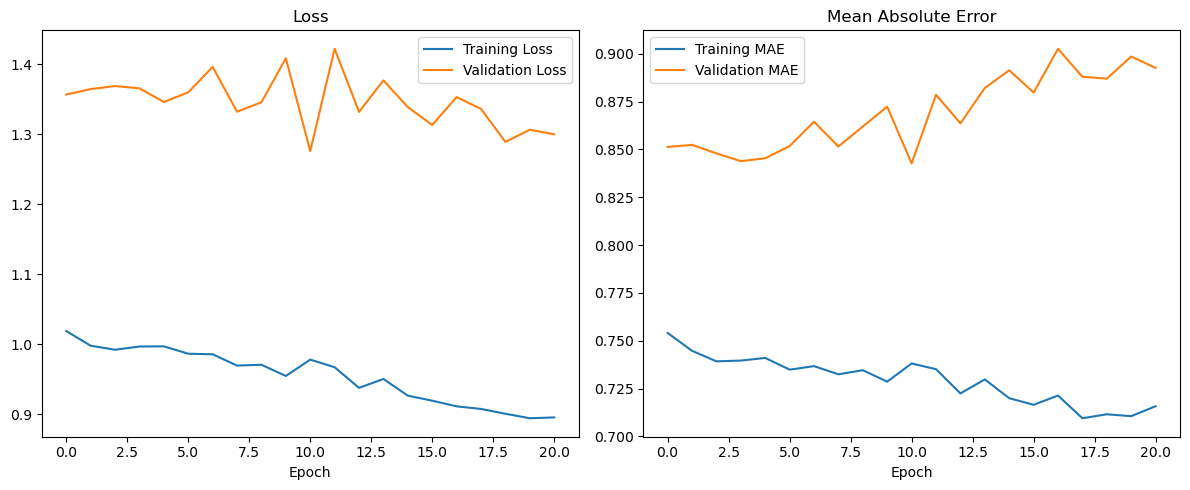

In [22]:

# Plot training history
plot_training_history(history)


In [23]:

# Evaluate model - note the variable name change
y_pred_changes, y_pred_close, y_test_close = evaluate_model(
    model,
    target_scaler,
    X_test_scaled,
    y_test,
    test_reference_prices  # Using reference_prices instead of noon_prices
)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step

=== Model Evaluation ===
Price Change Metrics:
  MSE: 10.9859
  MAE: 2.4470
  RMSE: 3.3145

Close Price Metrics:
  MSE: 10.9859
  MAE: 2.4470
  RMSE: 3.3145

Mean Values:
  Mean Predicted Change: -0.0115
  Mean Actual Change: -0.2552
  Mean Predicted Close: 593.4704
  Mean Actual Close: 593.2267
  Average prediction offset: -0.2437

Directional Accuracy: 59.55%


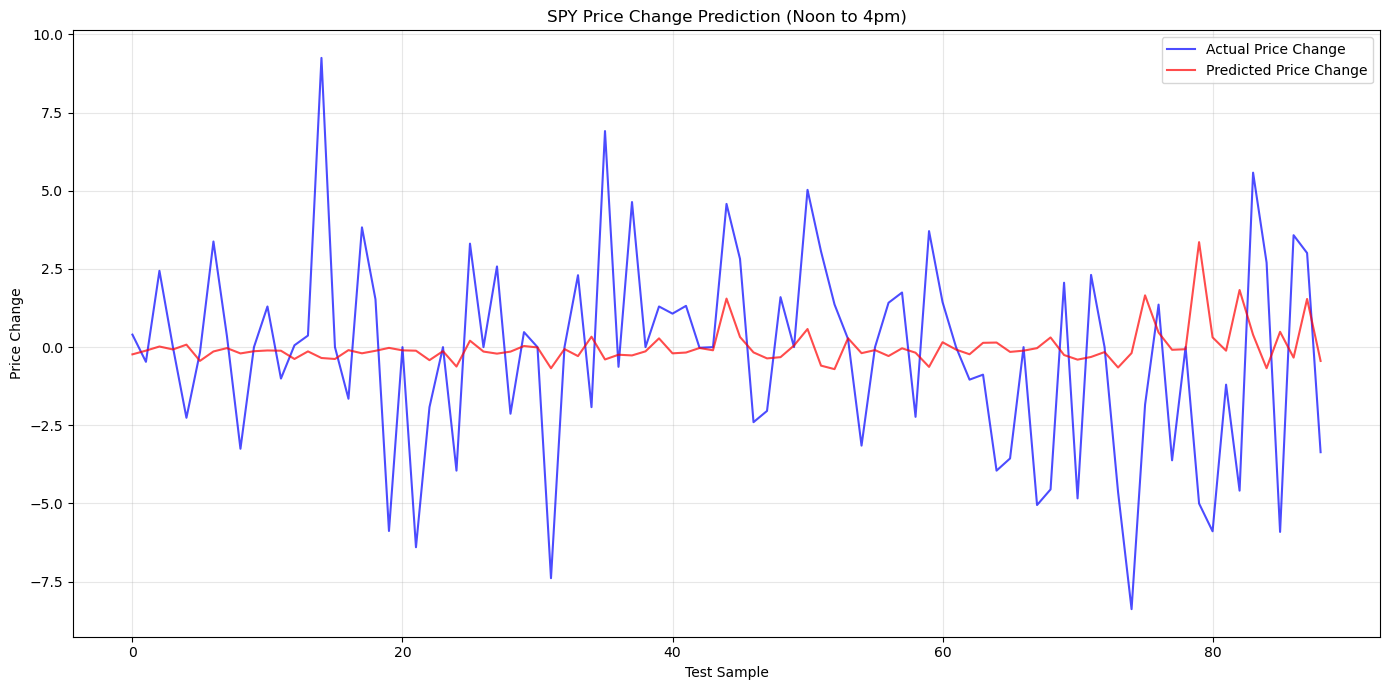

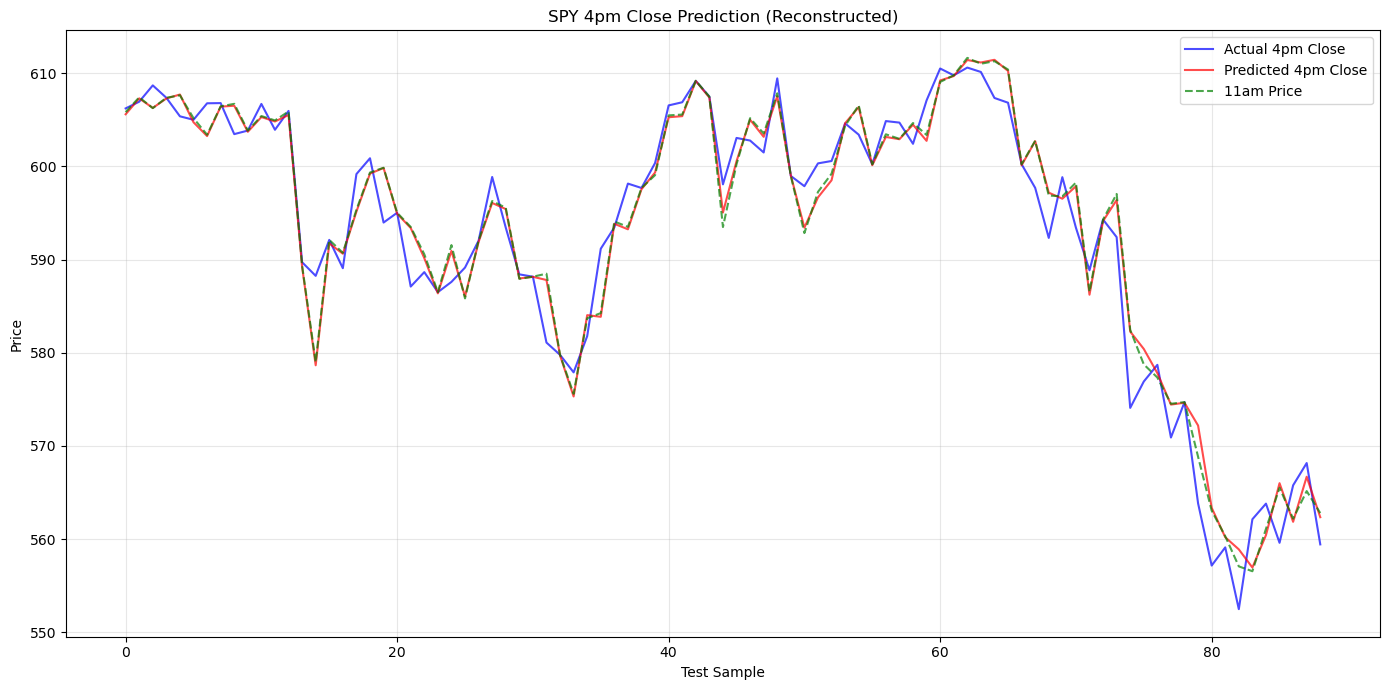

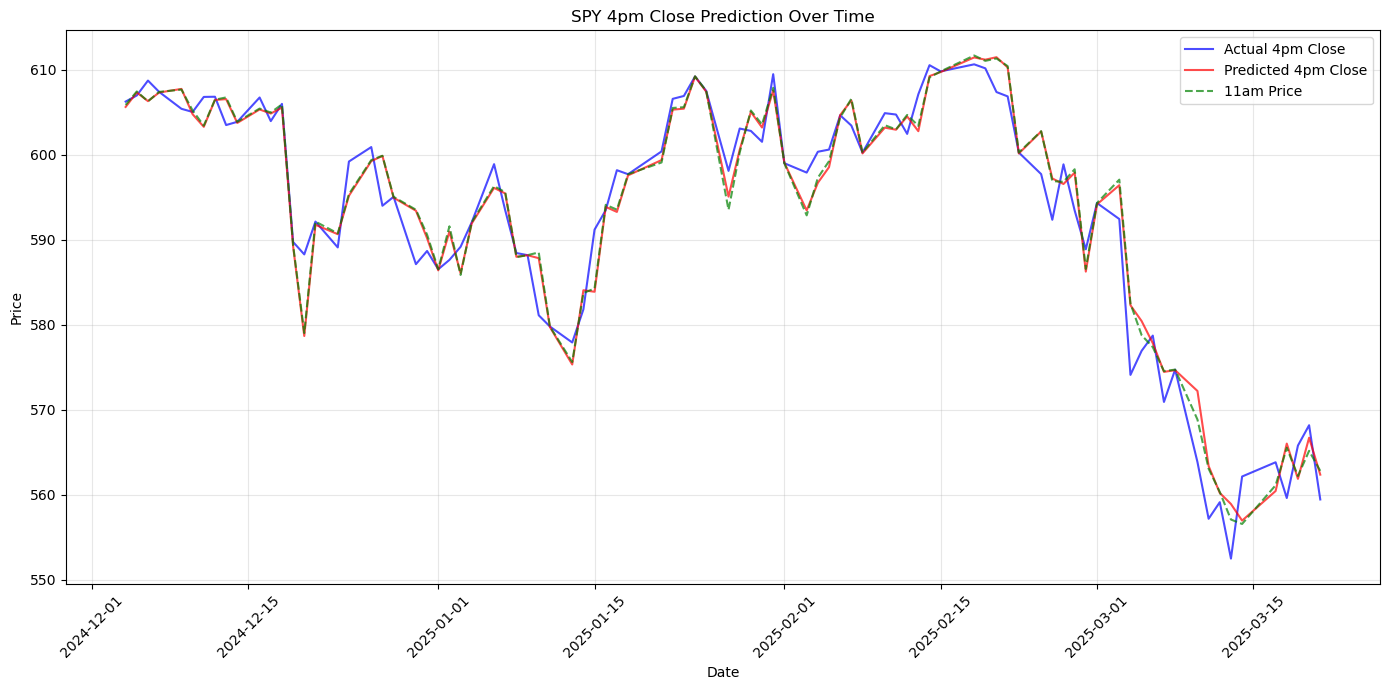

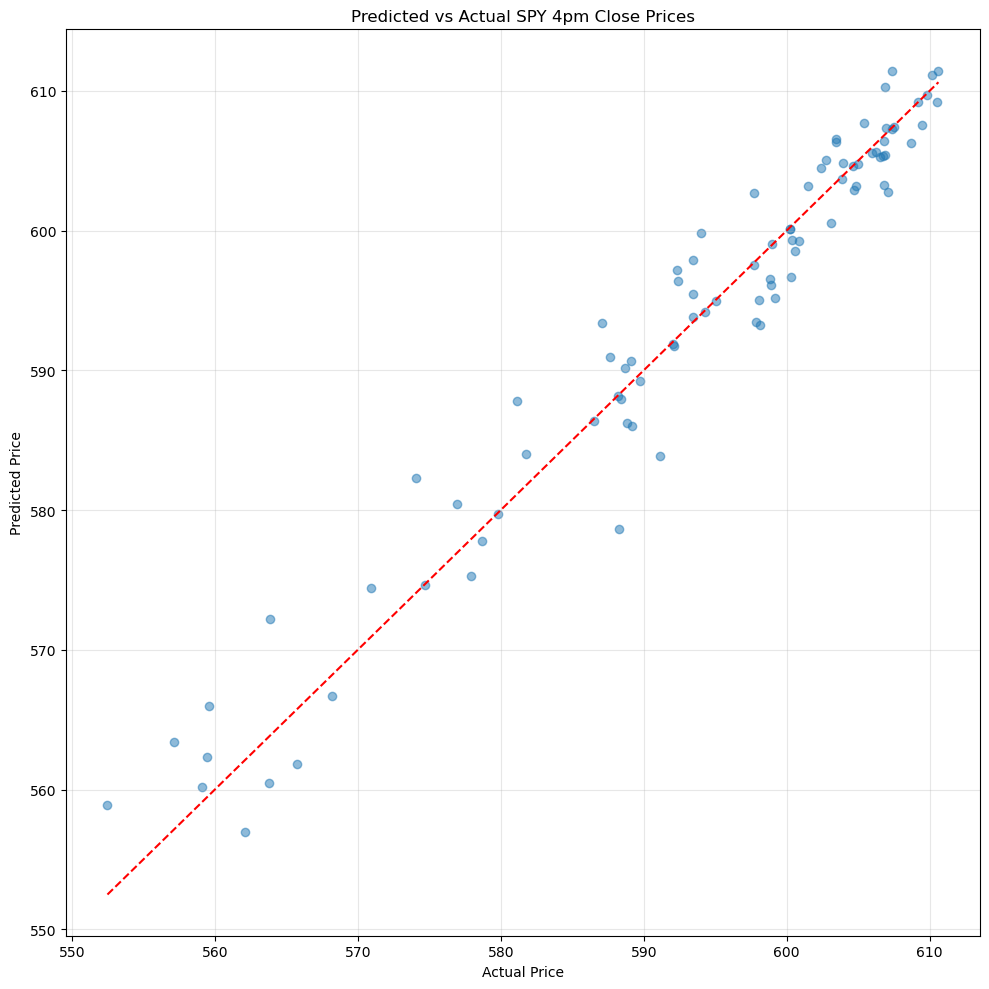

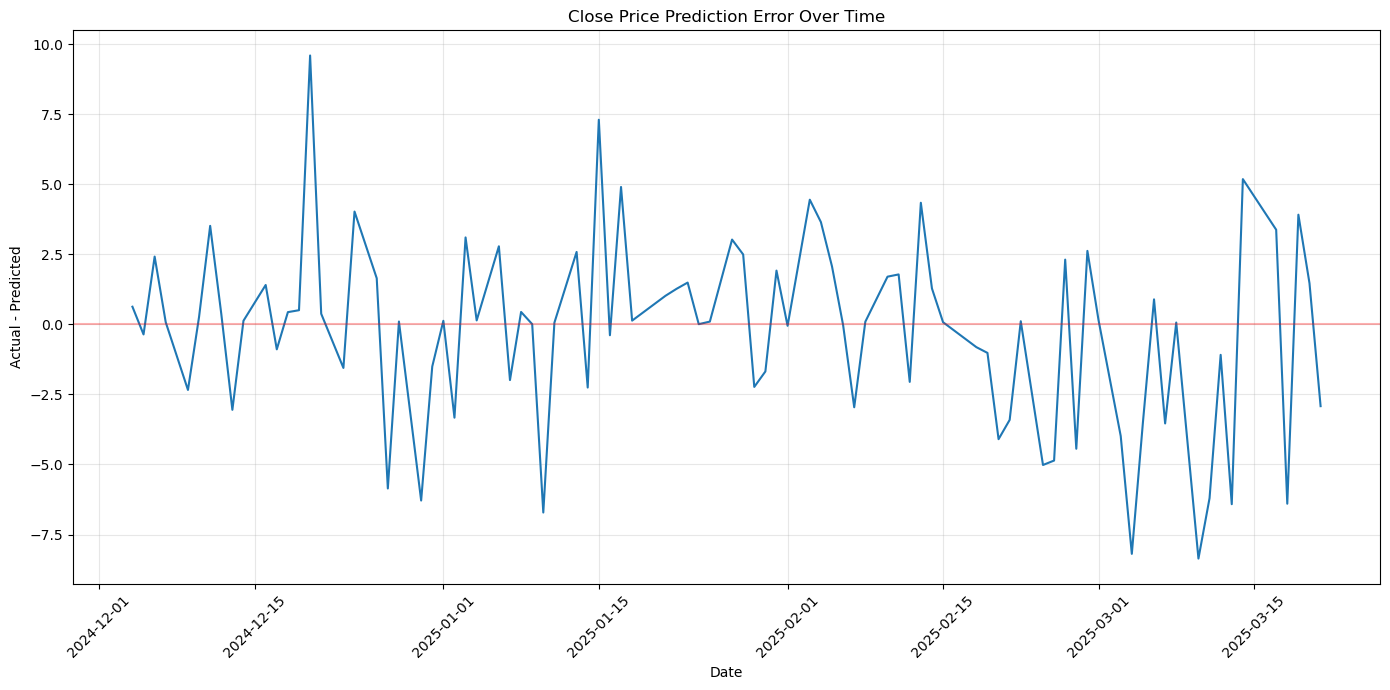

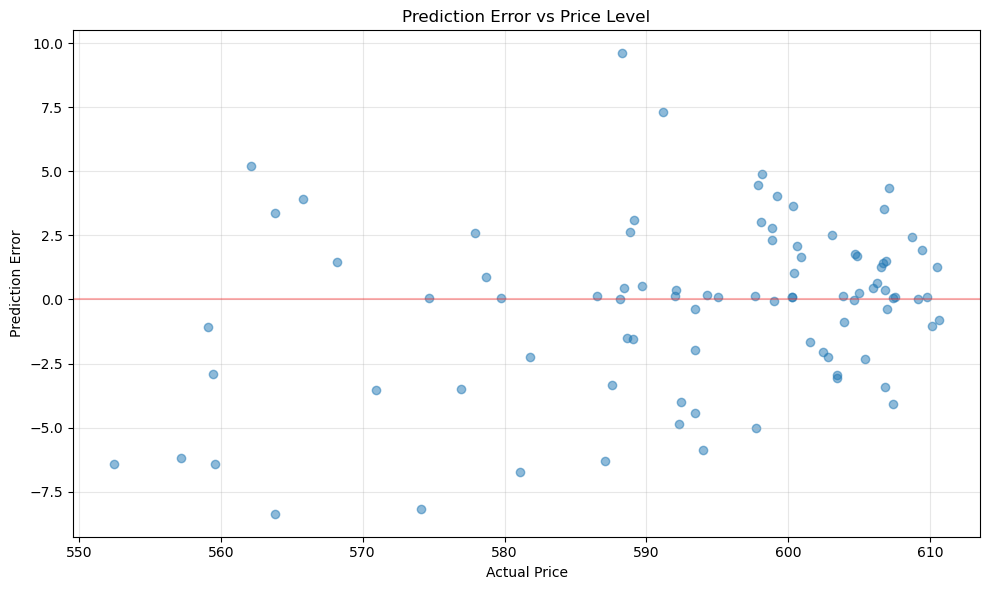

Model training and evaluation complete!


In [24]:

# Plot predictions - note the variable name change
plot_predictions(
    y_test,
    y_pred_changes,
    y_test_close,
    y_pred_close,
    test_reference_prices,  # Using reference_prices instead of noon_prices
    test_dates
)

print("Model training and evaluation complete!")

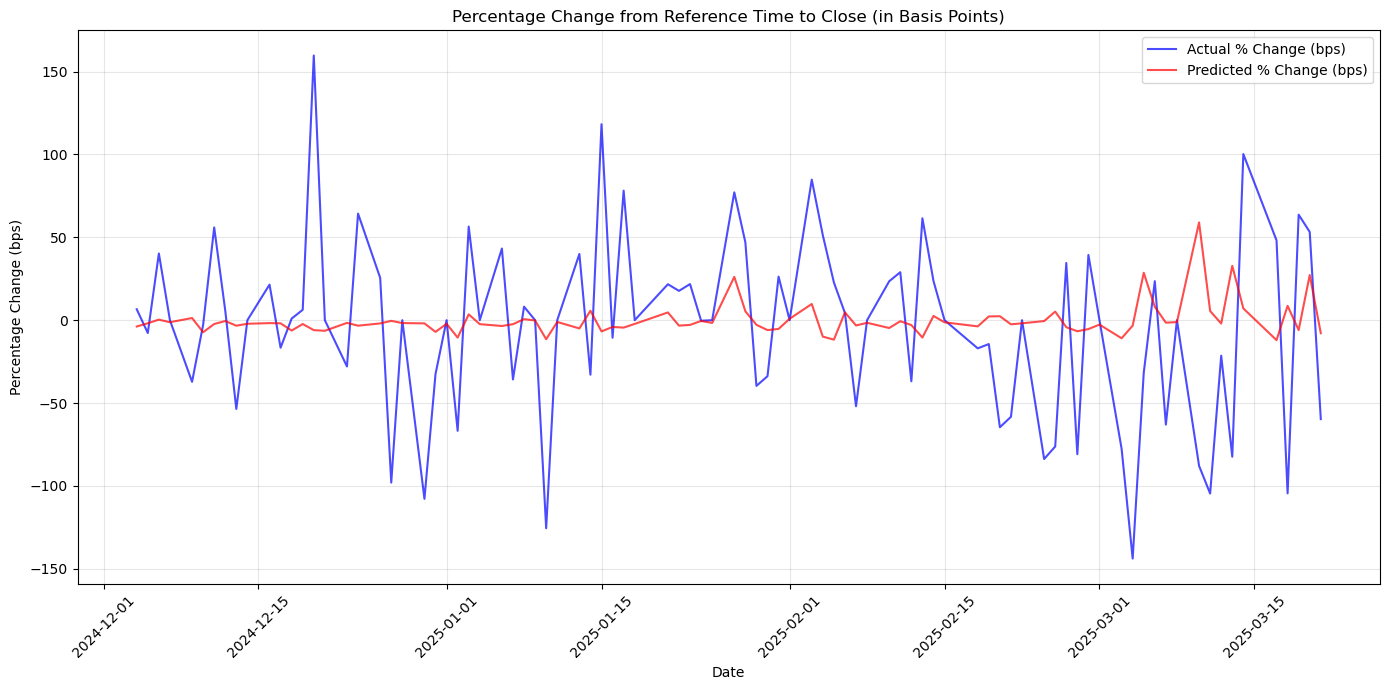

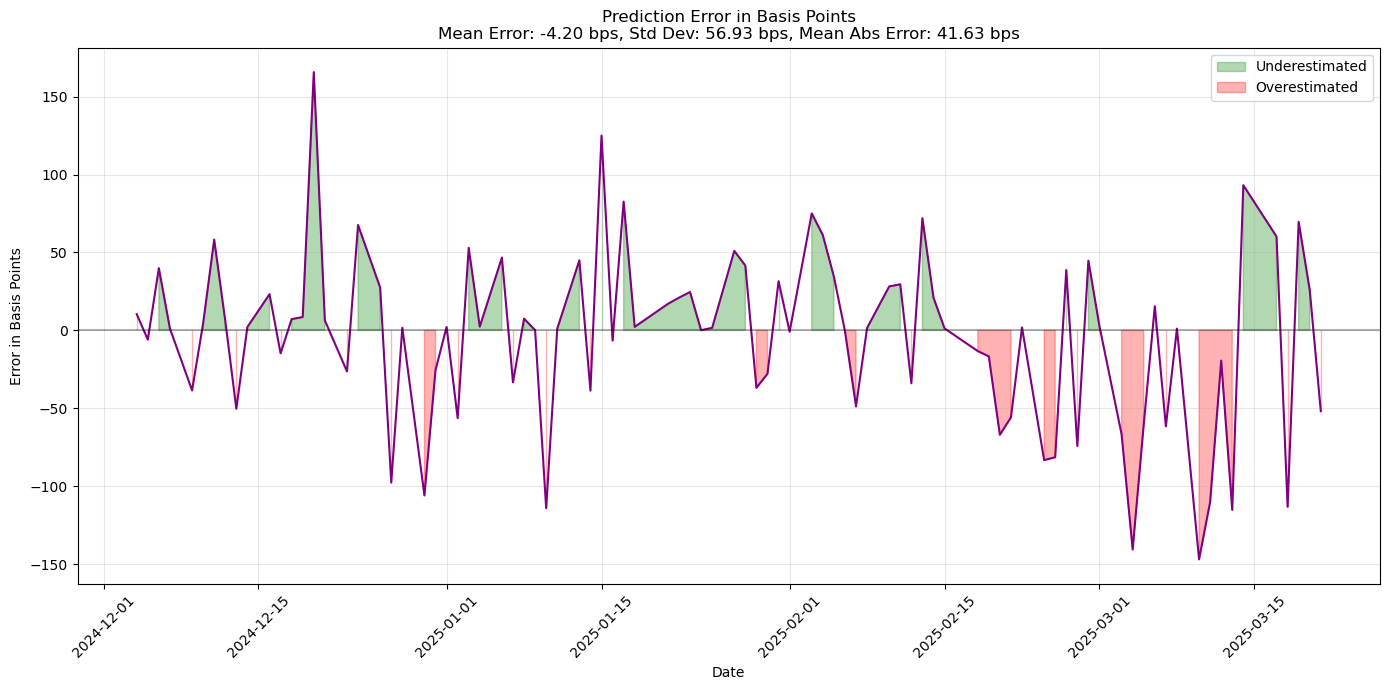

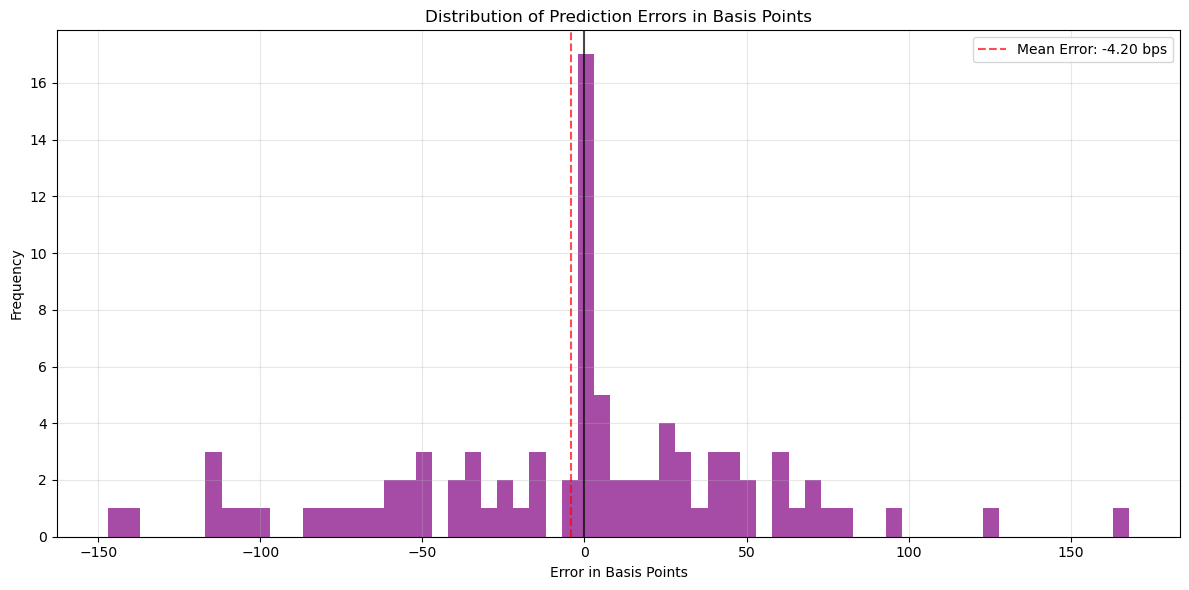

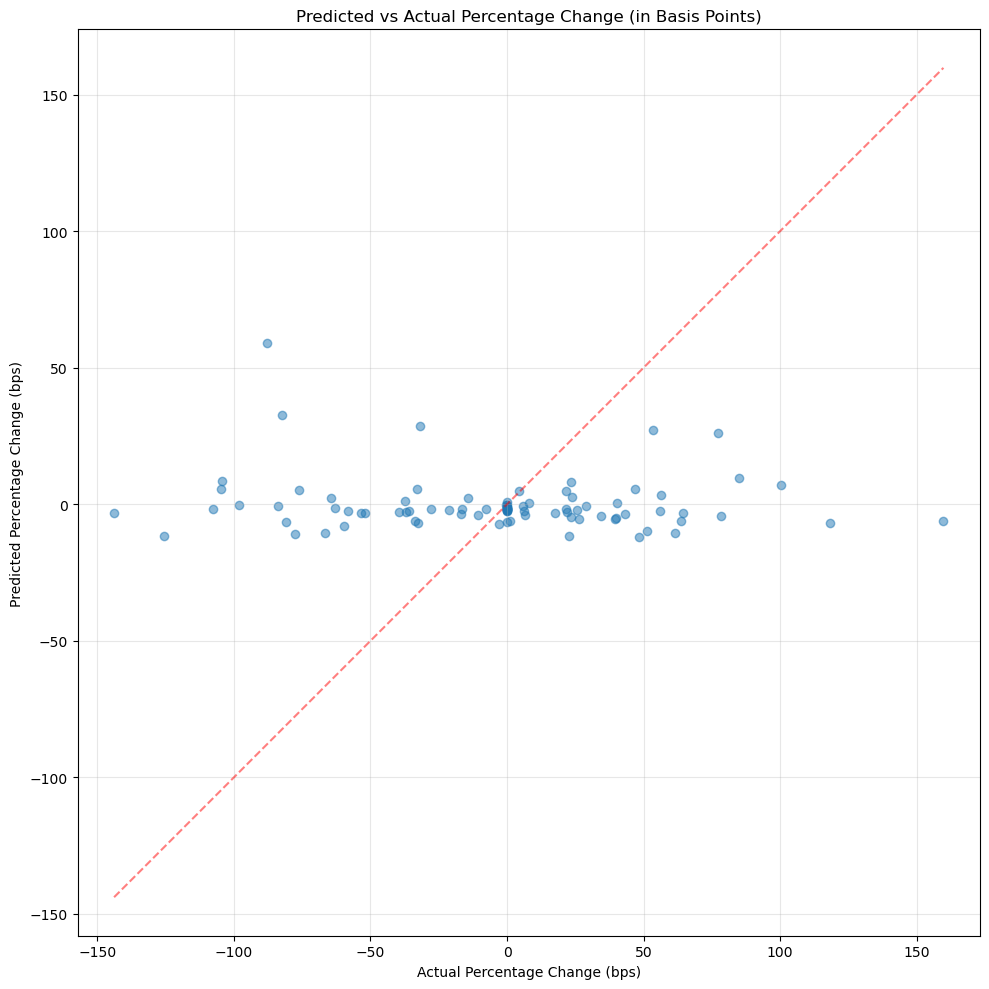

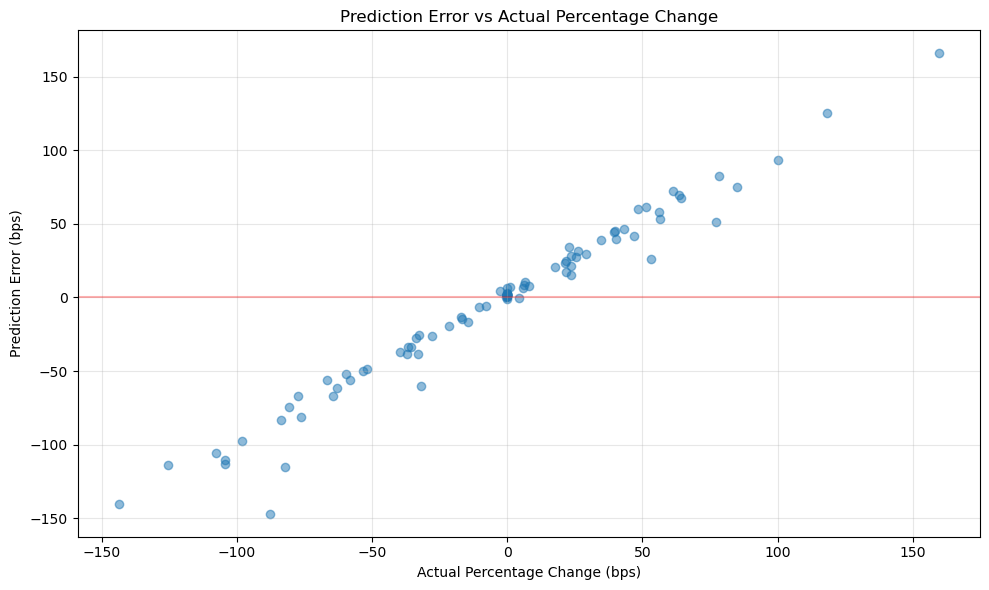


===== Percentage Basis Points Prediction Summary =====
Mean Percentage Change Error: -4.20 bps
Standard Deviation of Error: 56.93 bps
Mean Absolute Error (MAE): 41.63 bps
Min Error: -146.92 bps
Max Error: 165.76 bps
Directional Accuracy: 42.70%

Days with large prediction errors (>50 bps):
         date  reference_price  actual_close  predicted_close  \
6  2024-12-11           603.40      606.7783       603.261156   
8  2024-12-13           606.72      603.4700       606.518617   
14 2024-12-20           579.01      588.2600       578.662331   
17 2024-12-24           595.35      599.1800       595.152557   
19 2024-12-27           599.86      593.9800       599.835860   
21 2024-12-30           593.51      587.1100       593.395908   
24 2025-01-02           591.56      587.6100       590.939175   
25 2025-01-03           585.84      589.1500       586.046020   
31 2025-01-10           588.49      581.1000       587.814305   
35 2025-01-15           584.26      591.1700       583.865

In [25]:
# After you've run your model and have the prediction results:

# First, make sure you have these variables from your model evaluation:
# - test_dates: dates in your test set
# - test_reference_prices: the 11 AM prices
# - y_pred_close: the predicted 4 PM close prices
# - y_test_close: the actual 4 PM close prices

# Now call the new function to plot percentage basis points:
results_df = plot_percentage_basis_points(
    test_dates,
    test_reference_prices,
    y_pred_close,
    y_test_close
)

# If you want to examine specific days with large errors:
large_errors = results_df[abs(results_df['prediction_error_bps']) > 50]
print("\nDays with large prediction errors (>50 bps):")
print(large_errors[['date', 'reference_price', 'actual_close', 'predicted_close', 'prediction_error_bps']])

# If you want to analyze performance by month:
results_df['month'] = pd.DatetimeIndex(results_df['date']).month
monthly_performance = results_df.groupby('month')['prediction_error_bps'].agg(['mean', 'std', 'count'])
print("\nMonthly prediction error analysis:")
print(monthly_performance)

# If you want to see the performance for up days vs down days:
up_days = results_df[results_df['actual_pct_change_bps'] > 0]
down_days = results_df[results_df['actual_pct_change_bps'] < 0]

print("\nPerformance on up days:")
print(f"Mean Error: {up_days['prediction_error_bps'].mean():.2f} bps")
print(f"Mean Absolute Error: {up_days['prediction_error_bps'].abs().mean():.2f} bps")
print(f"Number of up days: {len(up_days)}")

print("\nPerformance on down days:")
print(f"Mean Error: {down_days['prediction_error_bps'].mean():.2f} bps")
print(f"Mean Absolute Error: {down_days['prediction_error_bps'].abs().mean():.2f} bps")
print(f"Number of down days: {len(down_days)}")